<a href="https://colab.research.google.com/github/RiverGumSecurity/IntroAILabs/blob/main/PhishingModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Hugging Face: Phishing Classification Model

In this lab/demo, we are going to use a pre-trained AI classification model for email phishing. This model is able to
injest text or html data, and classify it as either "benign" or "phishing". This pre-trained model leverages BERT from Google
which was trained in 2018. The concept of leveraging BERT, a natural language processing (NLP) model, and extending the training for 
a specific task is known as **transfer learning**.

It is important to understand that a tremendous amount of the statistical and mathematical operations needed to build and use AI models are being abstracted away when you use a pre-trained model interface/API. This is actually a good thing for us, as training your own model is a specialized skill that requires some understanding of the underlying statistical theory, and even better, an understanding of the underlying linear algebra that is commonly used for all vector based computational neural networks.

A common concept in natural language processing (NLP) is the idea of **tokenizing**. In it's simplest form, **tokenizing** is a process whereby string tokens (words or individual characters) are turned into mathematical vectors, otherwize known as matricies for ease of numerical computation. Since either words, or sentences do not have a fixed length, and a fixed two dimensional array (matrix) does have a limit, then we often are in the situation of truncating or padding data when performing the **tokenizing** process.

In this first Jupyter notebook cell, we use the huggingface_hub, and transformers Python modules. Both are designed to facilitate the download and use of pre-trained AI models. Some points to note as follows:

* [**huggingface_hub.snapshot_download()**](https://huggingface.co/docs/huggingface_hub/v0.24.2/en/package_reference/file_download#huggingface_hub.snapshot_download) is used to download a snapshot of the entire AI model repository.
* [**transformers.AutoTokenizer.from_pretrained()**](https://huggingface.co/docs/transformers/v4.43.0/en/model_doc/auto#transformers.AutoTokenizer.from_pretrained) is used to create a text tokenizer object from a pre-trained model.
* [**transformers.AutoModelForSequenceClassification.from_pretrained()**](https://huggingface.co/docs/transformers/v4.43.0/en/model_doc/auto#transformers.AutoModelForSequenceClassification) is used to create a model object from which predictions can be made.
* [**transformers.pipeline()**](https://huggingface.co/docs/transformers/en/main_classes/pipelines) is a very high level powerful functional abstraction that allows you to feed input data to an AI model for a prediction without the complex statistical API calls which are being used within the pipeline() abstraction.
    * Please note the function argument **device='mps'** is included so that the pipeline leverages the MacOS MPS GPU core for processing.
 
### **bert-finetuned-phishing** Model Accuracy Claims

According to the hugging face published document, this model achieves the following results on the evaluation dataset:

* Loss: 0.1953
* Accuracy: 0.9717
* Precision: 0.9658
* Recall: 0.9670
* False Positive Rate: 0.0249

### Our Goals

Analyze the original training dataset, and evaluate from an alternative dataset whether this accuracy claim seems
correct to us. 


In [286]:
#################################################
## Hugging Face Phishing Model Demo
## Author: Joff Thyer, Copyright (c) July 2024
#################################################
import huggingface_hub
import transformers
import pathlib
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# Read your Hugging Face API key from home dir.
HF_APIKEY = ''
with open(pathlib.Path.home() / '.hfkey') as hf:
    HF_APIKEY = hf.read().strip()

model_name = "ealvaradob/bert-finetuned-phishing"
dpath = huggingface_hub.snapshot_download(repo_id=model_name, token=HF_APIKEY)
print(f'Model downloaded to: {dpath}')

# now setup a tokenizer, a model object, and a prediction object
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name, device='mps')
model = transformers.AutoModelForSequenceClassification.from_pretrained(model_name)
predict = transformers.pipeline('text-classification', model=model, tokenizer=tokenizer, device='mps', truncation=True)

Fetching 10 files:   0%|          | 0/10 [00:00<?, ?it/s]

Model downloaded to: /Users/joff.thyer/.cache/huggingface/hub/models--ealvaradob--bert-finetuned-phishing/snapshots/fa8fb73a007174c410ab7160d4e4c6e6b8d998d4


In [305]:
# original training dataset loaded here.
dataset = datasets.load_dataset("ealvaradob/phishing-dataset", "combined_reduced", trust_remote_code=True)
tempdf = dataset['train'].to_pandas()
train, test = train_test_split(tempdf, test_size=0.01, random_state=42)
test.replace({'label': 0}, 'benign', inplace=True)
test.replace({'label': 1}, 'phishing', inplace=True)

train, test = Dataset.from_pandas(train, preserve_index=False), Dataset.from_pandas(test, preserve_index=False)
print(f'train dataset: {train.shape}')
print(f'test dataset: {test.shape}')

train dataset: (76900, 2)
test dataset: (777, 2)


## Confusion Matrix

A confusion matrix is a table used to evaluate the performance of a classification algorithm. It is particularly useful for understanding how well a classifier is distinguishing between classes, especially in binary classification. The matrix compares the actual target values with the values predicted by the model. Here’s a breakdown of the components of a confusion matrix for binary classification.

Components:
* True Positive (TP): The number of instances correctly predicted as positive.
* True Negative (TN): The number of instances correctly predicted as negative.
* False Positive (FP): The number of instances incorrectly predicted as positive (Type I error).
* False Negative (FN): The number of instances incorrectly predicted as negative (Type II error).

In the case of phishing classification, we have a binary classifier, thus the components break down as:
* True Positive (TP): correctly classified as spam.
* True Negative (TN): correctly classified as not spam.
* False Positive (FP): incorrectly classified as spam.
* False Negative (FN): incorrectly classified as not spam.


Calculated Model Accuracy = 0.985843


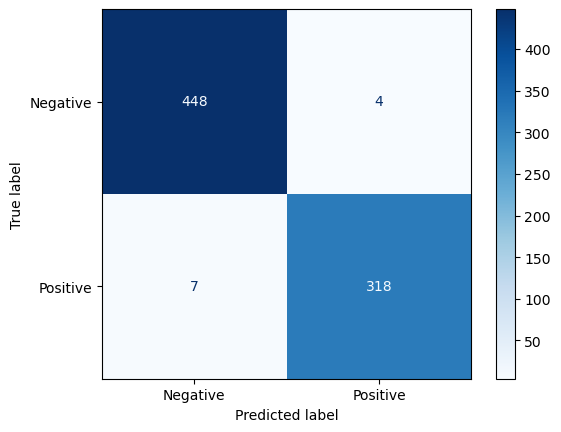

In [306]:
# confusion matrix example using test/train split.
y_test = [t['label'] == 'phishing' for t in test]
y_pred = [predict(t['text'])[0]['label'] == 'phishing' for t in test]
cm = confusion_matrix(y_test, y_pred)

accuracy = (cm[0][0] + cm[1][1]) / test.num_rows
print(f'Calculated Model Accuracy = {accuracy:02f}')

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
_ = disp.plot(cmap=plt.cm.Blues)

## Pandas

The Python module **Pandas** is an important and powerful module being used in data science.
Pandas provides two core concepts as Python classes known as a **Dataframe**, and a **Series**.
For natural language processing tasks, the **Dataframe** class is very commonly used.
In the below cell we are reading a dataset from a comma delimited file, replacing some column names, and then collecting some sample data from the data frame in order to make AI model predictions from that sample data.

* we import pandas and a common convention in data science is to alias it as **pd** in Python scripts
* in the code below we create two dataframes, "**source**" contains the full phishing email comma delimited dataset while "**df**" contains a subset that is sampled from the source.
* [**pd.read_csv()**](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html) is commonly used to read and process comma delimited data. It has many options as you can read in the documentation link, and it nicely allows you to use either a file name or URL to read data from.
* [**pd.dropna()**](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dropna.html) is used to drop any rows with NULL data in the dataframe. Using **inplace=True** allows us to mutate the dataframe inplace rather than having to assign the result to a new object.
* [**pd.replace()**](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.replace.html) is a very useful function for searching and replace data in an entire dataframe. It can perform simple string replacement or even use regular expressions if you have the need for more complex operations.
    * In our use case, the AI model we are using on prediction returns either the string "**phishing**" or "**benign**".
    * In the phishing labelled dataset, the labels are either "**Phishing Email**" or "**Safe Email**".
    * It is desirable to have the same nomenclature thus we use *replace* to fix this discrepency.
* [**pd.sample()**](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sample.html) allows us to take a sampling from a dataframe and return another dataframe. We choose a sample size that is manageable in terms of the real time execution time elapsed when making AI model predictions.
    * AI model predictions require linear algebraic computation which is always best performed on a vector processor design architecture such as Nvidia (CUDA based) Graphics Processing Units (GPU), or the [MacBook Pro M3 Meta Performance Shader (MPS) core](https://developer.apple.com/videos/play/tech-talks/111375/).
    * Pure CPU based calculation alone does work but is orders of magnitude slower.
* [**pd.assign()**](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.assign.html) is used to create a new column in the dataframe. In our use case this new column will become the prediction from the AI model so that we can store the prediction back to the same dataframe. We use a Python lambda function to create the number of rows in the new column to be the same as the length of the sampled dataframe structure.
* [**pd.shape**](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.shape.html) is an attribute of the dataframe class that contains the **(rows, columns)** in the dataframe.


In [289]:
import pandas as pd

source = pd.read_csv('https://github.com/RiverGumSecurity/Datasets/raw/main/Kaggle/Phishing_Email.csv.gz')
source.dropna(inplace=True)
source = source.replace('Phishing Email', 'phishing')
source = source.replace('Safe Email', 'benign')

sample_size = 2000
df = source.sample(sample_size)
df = df.assign(Prediction = lambda x: [None] * len(df))
df = df.assign(Score = lambda x: [None] * len(df))

print(f'The shape of the entire phishing dataset is: {source.shape}')
print(f'The shape of the sampled data frame is: {df.shape}')

The shape of the entire phishing dataset is: (18634, 3)
The shape of the sampled data frame is: (2000, 5)


## Making the AI Model do some predictive work!

This is where the rubber meets the road.  In the code below, we are looping through all of the data in our sampled "**df**" dataframe
and making some predictions using the "**predict**" pipeline object we created at the start of this notebook.
A few highlights to point out here:
* the logic within the loop uses an arbritrary random integer to print out a progress count of sorts. It is meaningless with regard to the actual prediction
* the "**predict**" object is passed the actual textual data and returns a Python dictionary inside a Python list. The dictionary has both a "**score**" and a "**label**" key in it. Since the label is a binary classification of *phishing* or *benign*, we only care about storing this result of the prediction using the "**label**" key to retrieve it.
* the Pandas [**pd.iat()**](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.iat.html) method is used to assign the resulting prediction label to a specific row number in the dataframe.
* the Python exception logic allows us to continue making predictions if there is some unknown failure at any specific row. It also allows us to catch the **KeyboardInterrupt** exception so that we can terminate the prediction loop early if we feel it is taking too long.


## TODO for LAB Work

* Count the number of mismatches in sampled data versus labelled data
* Think about how you might clean up the source data to lower the mismatch predictions

* 


In [290]:
# Make Model Predictions
import random
spin = r'\-/|+'
mm = 0
for i, row in enumerate(df['Email Text']):
    if not i % random.randint(3, 9):
        print(f'\r[{spin[i % len(spin)]}] Processed {i} rows of data.', end='', flush=True)
    try:
        p = predict(str(row))
        df['Prediction'].iat[i] = p[0]['label']
        df['Score'].iat[i] = p[0]['score']
        if df['Prediction'].iat[i] != df['Email Type'].iat[i]:
            mm += 1
    except KeyboardInterrupt:
        break
    except Exception as e:
        print(e)
        break
print(f'\r\n[+] Number of prediction / label mismatches: {mm}')
df.head(10)


[|] Processed 1998 rows of data.
[+] Number of prediction / label mismatches: 42


,Unnamed: 0,Email Text,Email Type,Prediction,Score
10114,10115,"Thanks for this, I'm going to give them anothe...",benign,benign,0.999995
18029,18030,"re : balance sheet review louise , a detailed ...",benign,benign,0.999995
3083,3083,"h e l l od e a rh o m eo w n e r , w eh a v eb...",phishing,phishing,0.99953
13647,13648,"no need to worry , you are always ready for it...",phishing,phishing,0.999993
15240,15241,[ wm ] ceviri yazilimlari html > Ýnternette ke...,phishing,phishing,0.99997
6010,6010,typological classification a few remarks on fr...,benign,benign,0.999994
10254,10255,"haven ' t seen you around hey , i just heard o...",phishing,phishing,0.999992
14951,14952,"if yours never get lon - ger , we ' ll ref - u...",phishing,phishing,0.999994
1058,1058,"""gubernatorial PRIMARY.""-----Original Message-...",benign,benign,0.999994
11315,11316,young teen sticky girl cum well wlle ! wet nxe...,phishing,phishing,0.999994


## Visualization with MatPlotLib

Being able to produce a good plot/chart to visualize results is critical for data science work.
Python's open source **matplotlib** does a great job for us in this area, and works very well
within Jupyter notebook. There are two basic modes you can use **matplotlib** in, *notebook* mode, or *inline* mode. Of these,
using it *inline* is the default and easiest method. In full *notebook* mode, there is ability to use interactive charts
however it requires tighter Python module integration and more software dependencies.

In this example, we create a single **figure**, and then use the **subplot** method to create two different
plots within the same figure so that we can compare the results side by side. Below is a list of methods used with links to
the related documentation.

* [**plt.figure()**](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.figure.html)
* [**plt.subplot()**](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplot.html)
    * Note: subplot() arguments are "rows", "cols", and "index".
    * in the example below, we create 1 x 2 subplots.
* [**plt.title()**](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.title.html)
* [**plt.xlabel()**](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.xlabel.html)
* [**plt.ylabel()**](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.ylabel.html)
* [**pandas.DataFrame.plot()**](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.html)




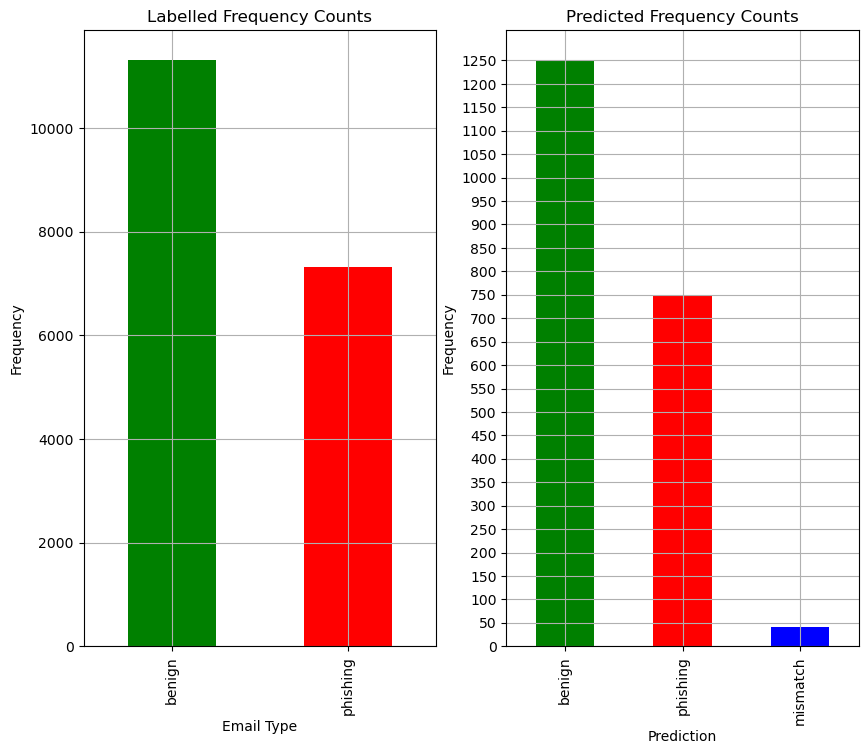

In [291]:
import matplotlib.pyplot as plt

# this is the default mode however we include for good measure.
%matplotlib inline

plt.figure(1, figsize=(10, 8))
ax1 = plt.subplot(1, 2, 1)
plt.title('Labelled Frequency Counts')
plt.xlabel('Categories')
plt.ylabel('Frequency')

ax2 = plt.subplot(1, 2, 2)
plt.title('Predicted Frequency Counts')
plt.xlabel('Categories')
plt.ylabel('Frequency')
_ = source['Email Type'].value_counts().plot(ax=ax1, kind='bar', color=['g', 'r'], label='SourceData', grid=True)

# create a new pandas series containing our counts
df2 = df.groupby(by = 'Prediction', as_index=True)['Prediction'].count()
df2['mismatch'] = mm
_ = df2.plot(ax=ax2, kind='bar', label='Prediction', color=['g', 'r', 'b'], grid=True, yticks=range(0, df2.max(), 50))



Calculated Model Accuracy = 0.979000


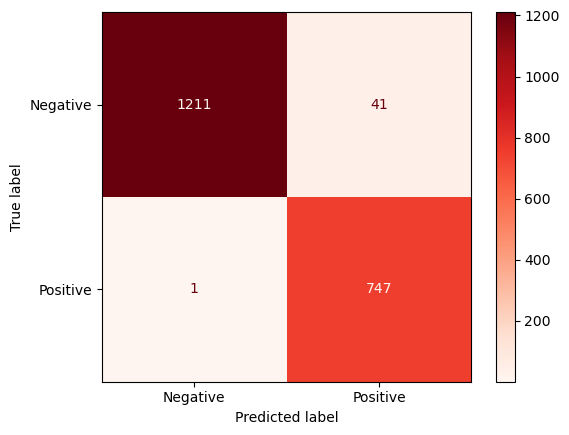

In [308]:
# confusion matrix example using sampled data.
y_test = [t == 'phishing' for t in df['Prediction']]
y_pred = [t == 'phishing' for t in df['Email Type']]
cm = confusion_matrix(y_test, y_pred)

accuracy = (cm[0][0] + cm[1][1]) / len(y_test)
print(f'Calculated Model Accuracy = {accuracy:02f}')

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
_ = disp.plot(cmap=plt.cm.Reds)